In [5]:
## Import different packages to be used
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
# Load the CSV file into a DataFrame and enter some details about the subject
eeg_data = pd.read_csv(input("Enter location of csv file which includes EEG for somnotate scoring: "))

#Select which channel you are interested in using for plotting spectrogram
eeg_channel = input("Which channel are you interested in plotting spectrogram - insert in EEG1 or EEG2 format: ")
sig_eeg = eeg_data[eeg_channel].values  # Extract as a NumPy ndarray

# Enter start time of the recording for determining ZT
start_time = input("Enter the start date and time in HH:MM:SS format: ")

# Set sampling rate, and create a times vector for plotting
fs = int(input("Sampling rate of signal in Hz: "))

#Enter details about the subject
sub = input("Enter subject ID: ")
extra_info = input("Any extra details about the recording: ")
epoch_duration = int(input("Enter length of epoch for exponent analysis in seconds: "))



In [ ]:
## Use neurodsp to determine the PSD for both channels at the epoch of interest

# Calculate total recording time in seconds and number of bins
recording_seconds = len(eeg_data) / fs  # Assuming all channels have the same length
num_bins = int(recording_seconds // epoch_duration)  # For the entirety of recording length

# Calculate number of samples per bin
samples_per_bin = fs * epoch_duration

# Prepare a dictionary to store PSD values and frequency data for each channel
psd_values_dict = {}
frequencies = None  # Frequencies are the same for each bin

# Define a small number (epsilon) to add to 0 values
epsilon = 1e-10

# Loop over each EEG channel
for channel, sig in eeg_data.items():
    # Initialize a list to store PSD values for the current channel
    psd_values_dict[channel] = []

    # Loop over each bin
    for i in range(num_bins):
        # Extract the data for the current bin
        start = i * samples_per_bin
        end = start + samples_per_bin
        bin_data = sig[start:end]
        
        # Compute the power spectrum for this bin
        freqs, psd = compute_spectrum(bin_data, fs, method='welch', avg_type='mean', nperseg=fs*2)
        
        # Store the PSD values
        psd_values_dict[channel].append(psd)
        
        # Store frequencies once
        if frequencies is None:
            frequencies = freqs

# Convert psd_values to NumPy arrays for easier handling
for channel in psd_values_dict:
    psd_values_dict[channel] = np.array(psd_values_dict[channel])

# Get the psd values for each EEG channel
psd_values_eeg1 = psd_values_dict['EEG1']
psd_values_eeg2 = psd_values_dict['EEG2']

psd_values_eeg1[psd_values_eeg1 == 0] = epsilon
psd_values_eeg2[psd_values_eeg2 == 0] = epsilon

In [4]:
## Use neurodsp to determine the PSD for selected channel at the epoch of interest

# Parameters
epsilon = 1e-10  # Small value to replace zeros in PSD

# Calculate total recording time in seconds and number of bins
recording_seconds = len(sig_eeg) / fs
num_bins = int(recording_seconds // epoch_duration)

# Calculate number of samples per bin
samples_per_bin = fs * epoch_duration

# Prepare a list to store PSD values and frequency data
psd_values = []
frequencies = None

# Loop over each bin
for i in range(num_bins):
    # Extract the data for the current bin
    start = i * samples_per_bin
    end = start + samples_per_bin
    bin_data = sig_eeg[start:end]
    
    # Compute the power spectrum for this bin using Welch's method
    freqs, psd = compute_spectrum(bin_data, fs, method='welch', avg_type='mean', nperseg=fs*2)
    
    # Store the PSD values
    psd_values.append(psd)
    
    # Store frequencies once
    if frequencies is None:
        frequencies = freqs

# Convert PSD values to a NumPy array
psd_values = np.array(psd_values)

# Replace zero values in PSD with epsilon
psd_values[psd_values == 0] = epsilon


In [14]:
## Add a zeitgeber time column to psd_values 

psd_values_rows = psd_values.shape[0]  # Number of rows in the PSD values array

# Step 1: Parse the input time string into a datetime object
start_time_parse = datetime.datetime.strptime(start_time, "%H:%M:%S")

# Step 2: Round the time to the nearest 10 seconds
seconds = start_time_parse.second
remainder = seconds % 10
if remainder >= 5:
    start_time_parse += datetime.timedelta(seconds=(10 - remainder))
else:
    start_time_parse -= datetime.timedelta(seconds=remainder)

# Step 3: Create a list of timestamps for every 10 seconds
time_stamps = [start_time_parse + datetime.timedelta(seconds=i * 10) for i in range(psd_values_rows)]

# Step 4: Convert the list of timestamps to an ndarray
time_stamps_array = np.array([ts.strftime("%H:%M:%S") for ts in time_stamps])

# Define the reference Zeitgeber Time (ZT=0 corresponds to 09:00:00)
zt_reference = datetime.datetime.strptime("09:00:00", "%H:%M:%S")

# Convert timestamps to ZT
zeitgeber_time_array = []
for time_str in time_stamps_array:
    # Parse time string into a datetime object
    time_obj = datetime.datetime.strptime(time_str, "%H:%M:%S")
    
    # Calculate the time difference in seconds
    time_diff_seconds = (time_obj - zt_reference).total_seconds()
    
    # Convert time difference to hours (ZT)
    zeitgeber_time = time_diff_seconds / 3600  # Convert seconds to hours
    
    # Wrap ZT values to fall within [0, 24)
    zeitgeber_time = zeitgeber_time % 24
    
    # Append to the ZT array
    zeitgeber_time_array.append(zeitgeber_time)

# Convert to a NumPy array
zeitgeber_time_array = np.array(zeitgeber_time_array)

# Display the Zeitgeber Time array
print("Zeitgeber Time Array:", zeitgeber_time_array)

# Example: Combine ZT with PSD values
psd_values_with_zt = np.column_stack((zeitgeber_time_array, psd_values))

# Display the updated array
print("PSD Values with Zeitgeber Time:")
print(psd_values_with_zt)

Zeitgeber Time Array: [7.03055556 7.03333333 7.03611111 ... 4.66666667 4.66944444 4.67222222]
PSD Values with Zeitgeber Time:
[[7.03055556e+00 1.30112776e+01 8.04181065e+01 ... 4.58664952e-03
  5.83033331e-03 4.91053101e-03]
 [7.03333333e+00 6.02437876e+00 6.03045328e+01 ... 5.53973575e-03
  9.05185462e-03 3.41230540e-03]
 [7.03611111e+00 3.61575759e+01 7.42364059e+01 ... 9.19418961e-03
  1.43305681e-02 9.82868012e-03]
 ...
 [4.66666667e+00 4.93666993e+00 4.80409684e+01 ... 3.73438856e-02
  3.64560754e-02 1.32150517e-02]
 [4.66944444e+00 4.36942994e+00 6.47167007e+01 ... 1.89164505e-02
  1.14263806e-02 3.69325378e-03]
 [4.67222222e+00 9.26920668e+00 8.63800364e+01 ... 4.71910459e-05
  3.94079239e-05 3.39152780e-05]]


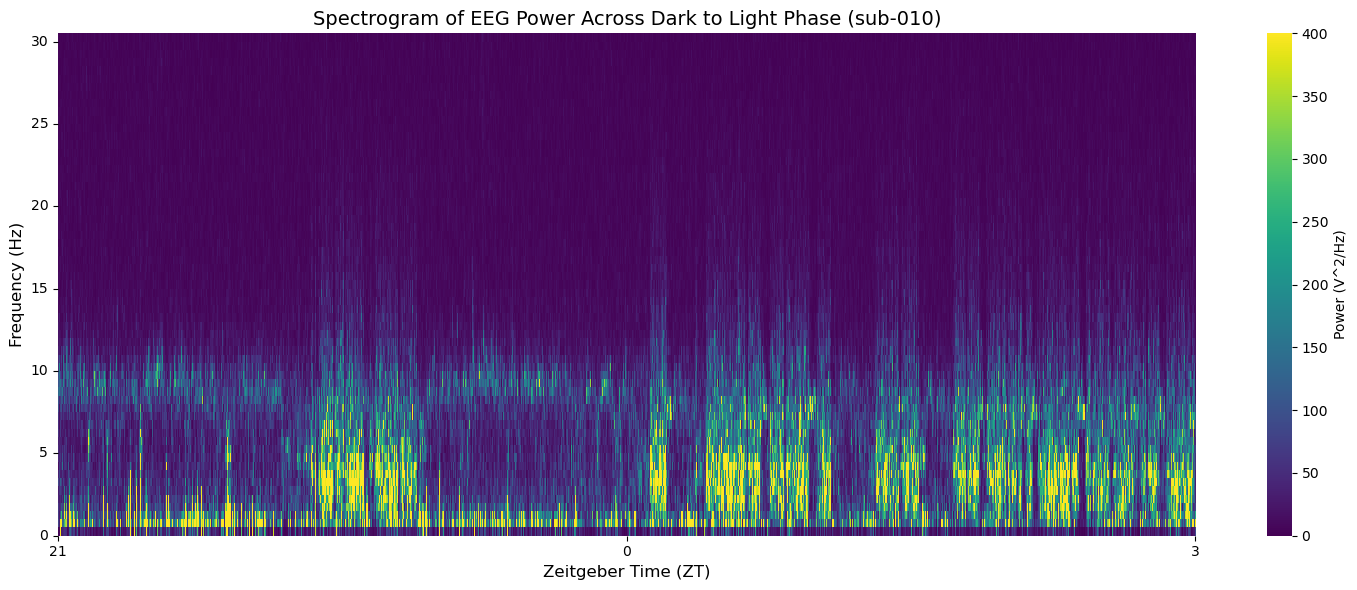

In [35]:
# Parameters
max_frequency = 30  # Maximum frequency to consider (Hz)
frequency_resolution = 0.5  # Resolution of each frequency column (Hz)
power_limit = 400  # Maximum power value for color bar

# Extract ZT range
zt_start_idx = np.where(psd_values_with_zt[:, 0] == 21)[0][0]  # First occurrence of ZT=21
zt_end_idx = np.where(psd_values_with_zt[:, 0] == 3)[0][0]     # First occurrence of ZT=3

# Slice the array to get the desired range and frequency range
selected_data = psd_values_with_zt[zt_start_idx:zt_end_idx + 1, :]  # Select rows based on ZT
frequency_columns = int(max_frequency / frequency_resolution) + 1  # Number of columns up to 30 Hz
spectrogram_data = selected_data[:, 1:frequency_columns + 1]  # Exclude ZT column, select frequency columns
zt_values = selected_data[:, 0]  # ZT values for the x-axis
frequencies = np.arange(0, max_frequency + frequency_resolution, frequency_resolution)  # Frequency values

# Plot the spectrogram
plt.figure(figsize=(15, 6))
sns.heatmap(
    spectrogram_data.T,  # Transpose to align frequencies on y-axis and ZT on x-axis
    cmap="viridis",      # Color map for intensity
    vmin=0, vmax=power_limit,  # Set power range
    xticklabels=np.round(zt_values, 0).astype(int),  # Round ZT values to whole numbers for x-axis
    yticklabels=np.arange(0, max_frequency + 1, 10).astype(int),  # Frequency ticks every 5 Hz
    cbar_kws={'label': 'Power (V^2/Hz)'}  # Label for the color bar
)

# Customize axis
plt.xlabel("Zeitgeber Time (ZT)", fontsize=12)
plt.ylabel("Frequency (Hz)", fontsize=12)
plt.title(f"Spectrogram of EEG Power Across Dark to Light Phase ({sub})", fontsize=14)

# Flip the frequency axis
plt.gca().invert_yaxis()

# Show x-axis ticks every 3 hours
zt_tick_indices = np.arange(0, len(zt_values), int(3 / (zt_values[1] - zt_values[0])))  # Spacing for 3-hour intervals
plt.xticks(zt_tick_indices, labels=np.round(zt_values[zt_tick_indices].astype(int)), rotation=0)

# Show frequency ticks every 5 Hz on the y-axis
plt.yticks(np.arange(0, len(frequencies), 10), labels=frequencies[::10].astype(int))  # Ticks every 5 Hz

plt.tight_layout()
plt.savefig(f"Z:/volkan/fooof/figures/spectrogram/{sub}_{extra_info}_spectrogram_dark_to_light.png")
